In [11]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("D:/Github/note/module")                                    # for windows
# sys.path.append("/Users/xinc./Documents/GitHub/note/module")    # for mac
from glob import glob
from get_info_TWSE import GetInfoTWSE
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.sandwich_covariance import cov_hac
from pprint import pprint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# get data

In [89]:
list = pd.read_csv("stock_id_list.csv")
list = list["Code"].to_list()

In [ ]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

fetcher = GetInfoTWSE()
for id in tqdm(list):
    try:
        df = fetcher.init_df(str(id), "2020-01-01", "2025-09-04")
        df = fetcher.get_stock_price()
        df = fetcher.get_day_trading_info()
        df.to_csv(f"data/{id}.csv", index = True)
    except:
        continue

  2%|▏         | 23/1066 [1:09:12<37:15:10, 128.58s/it]

# Analyse

In [3]:
file = pd.read_csv("data/1108.csv", index_col = "Date")
file["o_c_spread"] = file["Open"] - file["Close"]
file.dropna(inplace = True)

In [18]:
file

,Open,High,Low,Close,Volume,當日沖銷交易成交股數,當日沖銷交易買進成交金額,當日沖銷交易賣出成交金額,當沖佔交易量比例,BiasNorm,o_c_spread,target
Date,,,,,,,,,,,,
2020-01-02,8.38,8.45,8.28,8.37,310216.0,52000,432520,436540,0.167625,-0.004626,0.01,0.03
2020-01-03,8.40,8.40,8.28,8.37,239000.0,22000,183680,183890,0.092050,-0.000571,0.03,0.16
2020-01-06,8.37,8.37,8.21,8.21,191975.0,22000,180900,182790,0.114598,-0.005197,0.16,0.09
2020-01-08,8.24,8.28,8.15,8.15,94000.0,9000,73560,73620,0.095745,-0.000408,0.09,-0.03
2020-01-09,8.15,8.22,8.15,8.18,120076.0,3000,24450,24660,0.024984,-0.004276,-0.03,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-28,15.25,15.35,15.25,15.25,137908.0,1000,15300,15250,0.007251,0.001637,0.00,-0.05
2025-08-29,15.30,15.45,15.30,15.35,337529.0,6000,92350,92150,0.017776,0.001084,-0.05,0.05
2025-09-01,15.40,15.40,15.25,15.35,333990.0,3000,45950,46050,0.008982,-0.001087,0.05,0.05


### 看資料傾向

In [2]:
"""concat 成 panel data and sort"""

files = glob("data/*.csv")
dfs = []
for f in files:
    stock_id = f.split("\\")[-1].replace(".csv","")
    df = pd.read_csv(f, parse_dates = ["Date"])
    if df.empty:
        print(f"{stock_id} is empty")
        continue
    df["stock"] = stock_id
    df["c_o_ret"] = (df["Close"] - df["Open"]) / df["Open"]         # 建立 (Close - Open) / Open
    df["c_o_ret_t+1"] = df["c_o_ret"].shift(-1)
    dfs.append(df)

ratio_sorted_df = pd.concat(dfs, ignore_index = True)
ratio_sorted_df = ratio_sorted_df.sort_values(["Date","stock"])
ratio_sorted_df.dropna(inplace = True)
ratio_sorted_df = ratio_sorted_df.sort_values("當沖佔交易量比例").reset_index(drop = True)
ratio_sorted_df.reset_index(drop = True, inplace = True)
ratio_sorted_df.drop(index = ratio_sorted_df.index[1149120: ], inplace = True)

# 把 'stock' 移到第二個位置
cols = ratio_sorted_df.columns.tolist()
cols.remove("stock")
cols.insert(1, "stock")
ratio_sorted_df = ratio_sorted_df[cols]

# 累加 ret
ratio_sorted_df["cum_c_o_ret_t+1"] = ratio_sorted_df["c_o_ret_t+1"].cumsum()
mean = ratio_sorted_df["c_o_ret_t+1"].mean()
ratio_sorted_df["standardize"] = ratio_sorted_df["c_o_ret_t+1"] - mean
ratio_sorted_df["cum_standardize"] = ratio_sorted_df["standardize"].cumsum()

# print
ratio_sorted_df.to_csv("ratio_sorted_df")
ratio_sorted_df

7765 is empty


,Date,stock,Open,High,Low,Close,Volume,當日沖銷交易成交股數,當日沖銷交易買進成交金額,當日沖銷交易賣出成交金額,當沖佔交易量比例,BiasNorm,c_o_ret,c_o_ret_t+1,cum_c_o_ret_t+1,standardize,cum_standardize
0,2020-07-06,9937,45.55,45.65,45.30,45.35,40132871.0,1000.0,45600.0,45350.0,0.000025,0.002749,-0.004391,0.089617,0.089617,0.091236,9.123585e-02
1,2020-02-11,2816,20.55,20.75,20.55,20.65,52301791.0,3000.0,61850.0,62200.0,0.000057,-0.002821,0.004866,-0.004796,0.084821,-0.003178,8.805805e-02
2,2022-05-09,6166,56.30,58.00,56.30,57.50,22033628.0,2000.0,112800.0,114700.0,0.000091,-0.008352,0.021314,0.008772,0.093593,0.010390,9.844835e-02
3,2024-06-03,2331,37.70,37.70,37.70,37.70,10749518.0,1000.0,37700.0,37700.0,0.000093,0.000000,0.000000,-0.096250,-0.002657,-0.094632,3.816715e-03
4,2025-08-08,1438,38.00,38.50,38.00,38.50,10638294.0,1000.0,38500.0,38500.0,0.000094,0.000000,0.013158,0.009211,0.006554,0.010829,1.464561e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149115,2023-09-01,1470,19.25,19.25,19.25,19.25,1000.0,1000.0,19250.0,19250.0,1.000000,0.000000,0.000000,0.000000,-1859.651768,0.001618,3.791192e-02
1149116,2022-11-03,5906,31.45,31.45,30.85,30.85,2000.0,2000.0,62300.0,62300.0,1.000000,0.000000,-0.019078,0.000000,-1859.651768,0.001618,3.953029e-02
1149117,2021-02-25,8442,44.00,44.45,44.00,44.45,2000.0,2000.0,88450.0,88450.0,1.000000,0.000000,0.010227,-0.017719,-1859.669486,-0.016100,2.342994e-02
1149118,2025-05-15,5546,29.65,30.00,29.65,30.00,2000.0,2000.0,59650.0,59650.0,1.000000,0.000000,0.011804,-0.001667,-1859.671153,-0.000048,2.338164e-02


#### 畫圖

In [ ]:
def sorted_plot(ratio_sorted_df: pd.DataFrame, x: str, ly: str, max_ly: bool = False, ry: str | None = None):
    if x == "index":
        x = ratio_sorted_df.index / len(ratio_sorted_df)
    else:
        x = ratio_sorted_df[x]

    # 畫圖
    fig, ax1 = plt.subplots(figsize = (16, 5))

    # 左 y 軸：cum ret
    ax1.plot(x, ratio_sorted_df[f"{ly}"], label = f"{ly}", color = "tab:blue")
    ax1.set_xlabel("sample size")
    ax1.set_ylabel(f"{ly}", color = "tab:blue")
    ax1.tick_params(axis = "y", labelcolor = "tab:blue")
    if max_ly:
        y_values = ratio_sorted_df[ly]
        max_idx = y_values.idxmax()
        max_x = x[max_idx]
        print(f"max x index is {max_idx}")
        max_y = y_values[max_idx]
        ax1.scatter(max_x, max_y, color = "black", zorder = 5)
        ax1.axvline(max_x, color = "gray", linestyle = "--", linewidth = 1)  # 垂直線
        ax1.annotate(f"max={max_y:.2f}",
                    xy = (max_x, max_y),
                    xytext = (max_x, max_y + 20),
                    ha="center",
                    arrowprops = dict(facecolor = "black", shrink = 0.05),
                    fontsize = 9, color = "black")
        
    # 右 y 軸：當沖比例
    if ry:
        ax2 = ax1.twinx()
        ax2.plot(x, ratio_sorted_df[f"{ry}"], label = "day_trading ratio", color = "tab:red", linestyle = "--")
        ax2.tick_params(axis = "y", labelcolor = "tab:red")

    # 合併
    lines, labels = ax1.get_legend_handles_labels()
    if ry:
        assert ax2
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc = "center left", bbox_to_anchor = (1.05, 0.5))

    plt.grid(True)
    plt.tight_layout()
    plt.show()

max x index is 34148


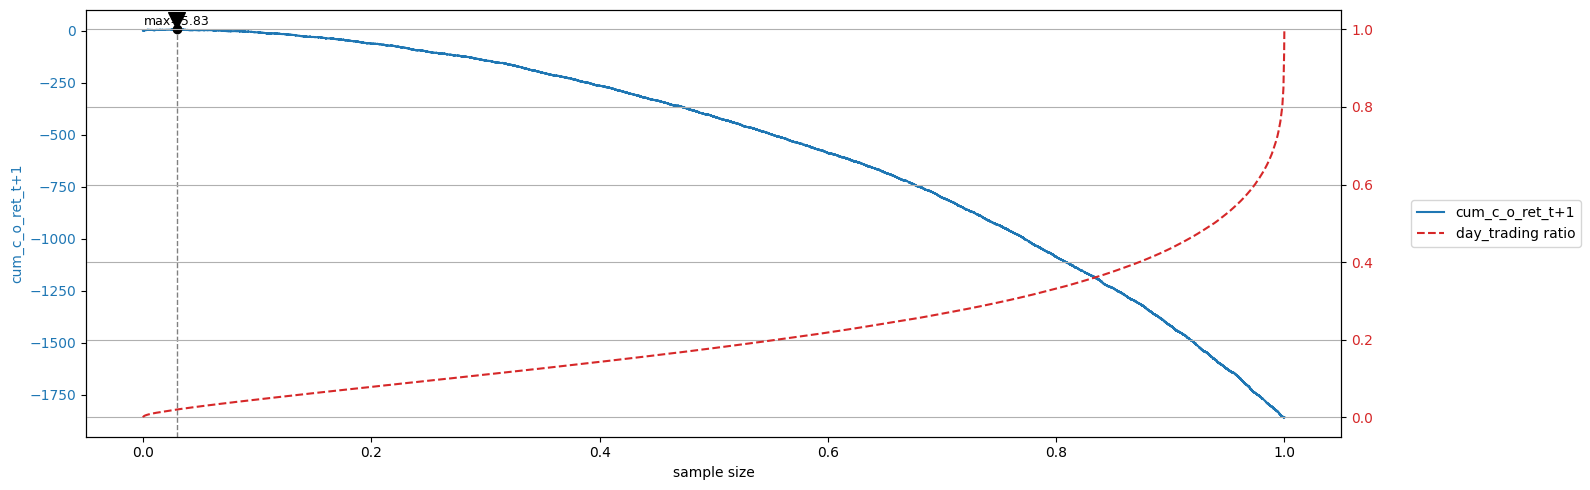

max x index is 720917


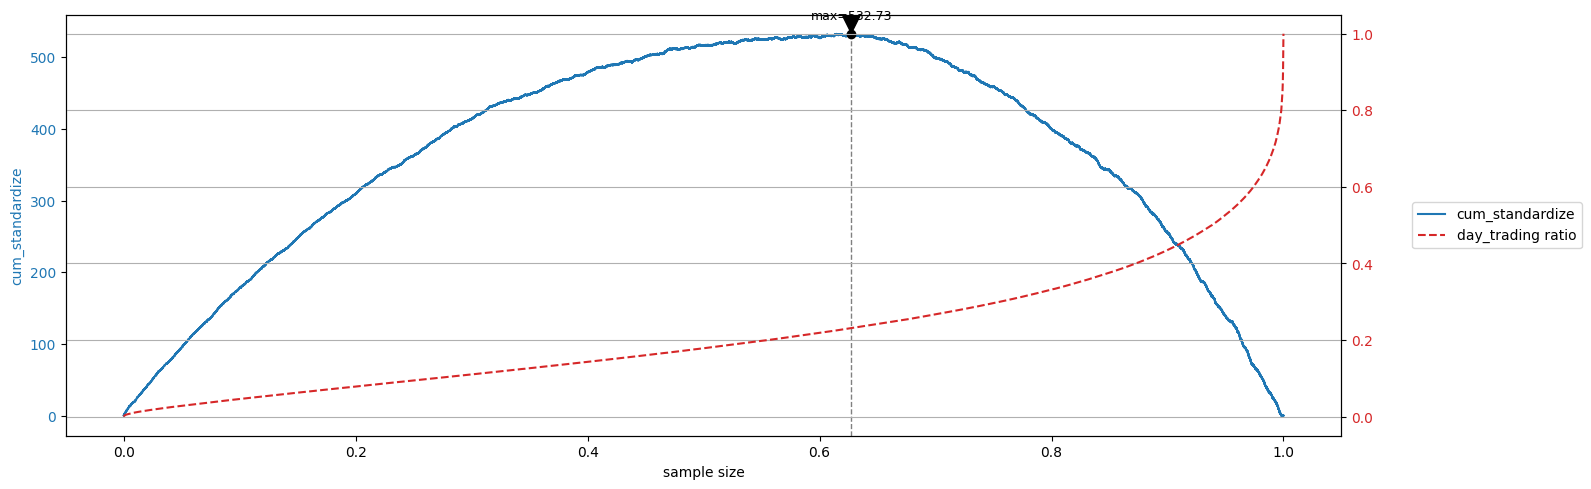

In [4]:
sorted_plot(ratio_sorted_df, "index", "cum_c_o_ret_t+1", max_ly = True, ry = "當沖佔交易量比例")
sorted_plot(ratio_sorted_df, "index", "cum_standardize", max_ly = True, ry = "當沖佔交易量比例")

In [10]:
"""maximization 的 standardize mean"""
right_df = ratio_sorted_df.loc[720917: ]
right_mean = right_df["standardize"].mean
right_mean()

np.float64(-0.0012440901439229077)

#### 分組檢驗

In [ ]:
def group(df: pd.DataFrame, col: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    對指定欄位進行分組統計與 t 檢驗，並回傳兩個報告表格。
    
    分組比例：0~20%、20~80%、80~100%
    """
    n = len(df)
    cut1 = int(n * 0.2)
    cut2 = int(n * 0.8)

    # 分組資料
    df1 = df.iloc[: cut1]
    df2 = df.iloc[cut1: cut2]
    df3 = df.iloc[cut2: ]
    g1 = df1[col].dropna()
    g2 = df2[col].dropna()
    g3 = df3[col].dropna()

    # 統計報告
    group_stats = {
        "mean": [g1.mean(), g2.mean(), g3.mean()],
        "std": [g1.std(), g2.std(), g3.std()],
        "count": [len(g1), len(g2), len(g3)],
        "missing": [
            df.iloc[:cut1][col].isna().sum(),
            df.iloc[cut1:cut2][col].isna().sum(),
            df.iloc[cut2:][col].isna().sum()
        ]
    }
    group_stats_df = pd.DataFrame(group_stats, index = ["Group1 (0~20%)", "Group2 (20~80%)", "Group3 (80~100%)"])

    # t 檢驗報告
    ttest_df = pd.DataFrame({
        "comparison": ["g1 vs g2", "g2 vs g3", "g1 vs g3"],
        "t-stat": [
            stats.ttest_ind(g1, g2, equal_var = False).statistic,
            stats.ttest_ind(g2, g3, equal_var = False).statistic,
            stats.ttest_ind(g1, g3, equal_var = False).statistic
        ],
        "p-value": [
            stats.ttest_ind(g1, g2, equal_var = False).pvalue,
            stats.ttest_ind(g2, g3, equal_var = False).pvalue,
            stats.ttest_ind(g1, g3, equal_var = False).pvalue
        ]
    })

    print(group_stats_df, "\n", ttest_df)

    return df1, df2, df3

In [ ]:
g1, g2, g3 = group(ratio_sorted_df, "當沖佔交易量比例")

                      mean       std   count  missing
Group1 (0~20%)    0.044910  0.020436  229824        0
Group2 (20~80%)   0.186486  0.069821  689472        0
Group3 (80~100%)  0.464390  0.111399  229824        0 
   comparison       t-stat  p-value
0   g1 vs g2 -1501.734361      0.0
1   g2 vs g3 -1124.579634      0.0
2   g1 vs g3 -1775.580563      0.0


In [32]:
results = {}
group_names = ["g1", "g2", "g3"]
groups = [g1, g2, g3]

for name, g in zip(group_names, groups):
    X = sm.add_constant(g["當沖佔交易量比例"])
    Y = g["standardize"]
    res = sm.OLS(Y, X).fit()
    results[name] = res

In [39]:
print(results["g3"].summary())

                            OLS Regression Results                            
Dep. Variable:            standardize   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     57.57
Date:                Wed, 10 Sep 2025   Prob (F-statistic):           3.27e-14
Time:                        20:52:46   Log-Likelihood:             4.8388e+05
No. Observations:              229824   AIC:                        -9.678e+05
Df Residuals:                  229822   BIC:                        -9.677e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.772      0.4

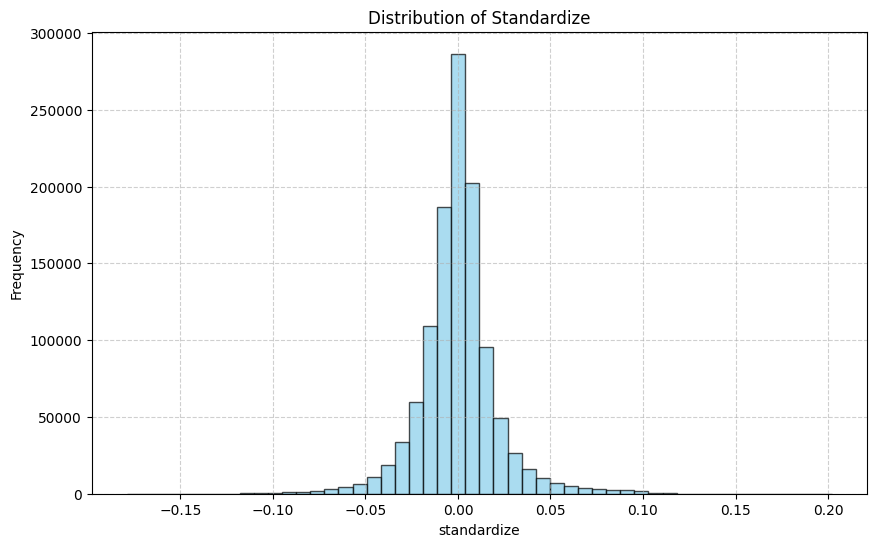

In [136]:
plt.figure(figsize = (10, 6))
plt.hist(ratio_sorted_df["standardize"].dropna(), bins = 50, color = "skyblue", edgecolor = "black", alpha = 0.7)
plt.title("Distribution of Standardize")
plt.xlabel("standardize")
plt.ylabel("Frequency")
plt.grid(True, linestyle = "--", alpha = 0.6)
plt.show()

In [ ]:
"""sorted by BiasNorm"""



## regression

### macro

In [ ]:
"""concat 成 panel data"""

files = glob("test_data/*.csv")
dfs = []
for f in files:
    stock_id = f.split("\\")[-1].replace(".csv","")
    df = pd.read_csv(f, parse_dates = ["Date"])
    df["stock"] = stock_id
    df["c_o_spread"] = df["Close"] - df["Open"]         # 建立 Close - Open
    df["c_o_spread_t+1"] = df["c_o_spread"].shift(-1)
    dfs.append(df)

ratio_sorted_df = pd.concat(dfs, ignore_index = True)
ratio_sorted_df = ratio_sorted_df.sort_values(["Date","stock"])
ratio_sorted_df.dropna(inplace = True)

# 把 'stock' 移到第二個位置
cols = ratio_sorted_df.columns.tolist()
cols.remove("stock")
cols.insert(1, "stock")
ratio_sorted_df = ratio_sorted_df[cols]

In [ ]:
"""fama macbeth regression"""

# cross sectional regression
rows = []
dates = []

vars_ = ["當沖佔交易量比例", "BiasNorm"]

for dt, g in ratio_sorted_df.groupby("Date"):
    Y = g["c_o_spread_t+1"]
    X = g[vars_]
    X = sm.add_constant(X)

    # 確保樣本不會太少
    if len(g) > X.shape[1] + 3:
        res = sm.OLS(Y, X).fit()
        rows.append(res.params.reindex(vars_).astype(float))
        dates.append(dt)

betas_df = pd.DataFrame(rows, index = pd.Index(dates, name = "Date")).sort_index()

# time series average
out = []
T = betas_df.shape[0]
X_time = sm.add_constant(np.ones(T))

# statistic
for col in betas_df.columns:
    series_t = betas_df[col].dropna()
    # 平均β
    beta_bar = series_t.mean()
    # NW-SE
    res_time = sm.OLS(series_t.values, X_time[:len(series_t)]).fit()
    cov = cov_hac(res_time)
    se_nw = np.sqrt(cov[0, 0])
    t_nw = beta_bar / se_nw
    out.append((col, beta_bar, se_nw, t_nw, len(series_t)))

res_table = pd.DataFrame(out, columns = ["var","beta_bar","SE_NW","t_NW","T"])
res_table

,var,beta_bar,SE_NW,t_NW,T
0,當沖佔交易量比例,-0.073933,0.049480,-1.494196,1379
1,BiasNorm,-6.838958,2.686327,-2.545839,1379


In [ ]:
X = file[["當沖佔交易量比例", "BiasNorm", "當日沖銷交易賣出成交金額"]]
X = sm.add_constant(X)
y = file["o_c_spread"].values

reg = sm.OLS(y, X, missing = "drop").fit()

# VIF
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [9]:
vif

,variable,VIF
0,const,2.882881
1,當沖佔交易量比例,1.264467
2,BiasNorm,1.015175
3,當日沖銷交易賣出成交金額,1.265735


In [10]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     70.93
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           1.40e-42
Time:                        19:59:25   Log-Likelihood:                 236.94
No. Observations:                1347   AIC:                            -465.9
Df Residuals:                    1343   BIC:                            -445.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0542      0.009      5.761   

### industry

In [53]:
import requests
import pandas as pd

stock = "2330"  # 台積電
url = f"https://openapi.twse.com.tw/v1/exchangeReport/BWIBBU_d?stockNo={stock}"
data = requests.get(url, timeout=30, verify = False).json()

df = pd.DataFrame(data)
df["市值(元)"] = pd.to_numeric(df["市值(百萬元)"], errors="coerce") * 1_000_000

print(df[["日期", "證券代號", "證券名稱", "市值(元)"]])


c:\Users\ownme\anaconda3\envs\quant\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openapi.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


KeyError: '市值(百萬元)'

## random forest

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

### naive random forest

In [16]:
"""預測方向"""

file["target"] = file["o_c_spread"].shift(-1)

data = file.dropna()

X = data[["當日沖銷交易賣出成交金額", "當沖佔交易量比例", "BiasNorm"]]
y = (data["target"] > 0).astype(int)

# 切資料
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[: split_point], X.iloc[split_point: ]
y_train, y_test = y.iloc[: split_point], y.iloc[split_point: ]

rf = RandomForestClassifier(
    n_estimators = 300,     # 樹的數量
    max_depth = None,       # 不限制深度
    class_weight = "balanced_subsample",
    n_jobs = -1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

# metrics
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average = "binary", zero_division = 0)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")
print("Confusion matrix:\n", cm)

# feature 重要性
imp = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})\
        .sort_values("Importance", ascending=False)

imp

Accuracy: 0.578 | Precision: 0.546 | Recall: 0.476 | F1: 0.509 | ROC-AUC: 0.561
Confusion matrix:
 [[97 49]
 [65 59]]


,Feature,Importance
2,BiasNorm,0.336074
0,當日沖銷交易賣出成交金額,0.335098
1,當沖佔交易量比例,0.328828


### target encoding random forest

In [17]:
def target_encode_timeseries(train: pd.DataFrame, valid: pd.DataFrame, col: str, target: str) -> pd.Series:
    """
    train: 訓練集 (只用過去資料)
    valid: 驗證集 (未來資料)
    col:   要做 target encoding 的欄位 (例如 'Industry')
    target: 標籤欄位 (例如 'target')
    """
    # get mean of train data
    mapping = train.groupby(col)[target].mean()

    # encode valid data by mean of train
    valid_encoded = valid[col].map(mapping)

    return valid_encoded

In [21]:
tscv = TimeSeriesSplit(n_splits = 5)
X = data[["Industry", "當沖佔交易量比例"]].copy()

KeyError: "['Industry'] not in index"